# Business Data Analytics
## Solutions for Homework 2

**Author:** Kamran Mammadzada

The notebook contains solutions for Homework 2 in Business Data Analytics (BDA) Course taught by Rajesh Sharma - University of Tartu.
Original Author of the homework questions - Anna Leontjeva.

__Task:__ Using housing data housing_data.csv predict the price of the house based on other features.

First let's load all the necessary data and libraries

In [35]:
# load libraries
library(tidyverse)
library(data.table) # helps with data import
library(lubridate) # helps with date manipulation
library(gridExtra) # helps visualize many graphs at once
library(modelr) # provides easy pipeline modeling functions
library(broom) # helps to tidy up model outputs
set.seed(456) # seed to ensure reproducibility

# load housing data
df <- read.csv("housing_data.csv")

Let's investigate and get to know our dataset

In [2]:
str(df)

'data.frame':	21613 obs. of  21 variables:
 $ id           : num  7.13e+09 6.41e+09 5.63e+09 2.49e+09 1.95e+09 ...
 $ date         : Factor w/ 372 levels "20140502T000000",..: 165 221 291 221 284 11 57 252 340 306 ...
 $ price        : num  221900 538000 180000 604000 510000 ...
 $ bedrooms     : int  3 3 2 4 3 4 3 3 3 3 ...
 $ bathrooms    : num  1 2.25 1 3 2 4.5 2.25 1.5 1 2.5 ...
 $ sqft_living  : int  1180 2570 770 1960 1680 5420 1715 1060 1780 1890 ...
 $ sqft_lot     : int  5650 7242 10000 5000 8080 101930 6819 9711 7470 6560 ...
 $ floors       : num  1 2 1 1 1 1 2 1 1 2 ...
 $ waterfront   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ view         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ condition    : int  3 3 3 5 3 3 3 3 3 3 ...
 $ grade        : int  7 7 6 7 8 11 7 7 7 7 ...
 $ sqft_above   : int  1180 2170 770 1050 1680 3890 1715 1060 1050 1890 ...
 $ sqft_basement: int  0 400 0 910 0 1530 0 0 730 0 ...
 $ yr_built     : int  1955 1951 1933 1965 1987 2001 1995 1963 1960 2003 ...
 $ yr_renovat

In [3]:
summary(df)

       id                         date           price            bedrooms     
 Min.   :1.000e+06   20140623T000000:  142   Min.   :  75000   Min.   : 0.000  
 1st Qu.:2.123e+09   20140625T000000:  131   1st Qu.: 321950   1st Qu.: 3.000  
 Median :3.905e+09   20140626T000000:  131   Median : 450000   Median : 3.000  
 Mean   :4.580e+09   20140708T000000:  127   Mean   : 540088   Mean   : 3.371  
 3rd Qu.:7.309e+09   20150427T000000:  126   3rd Qu.: 645000   3rd Qu.: 4.000  
 Max.   :9.900e+09   20150325T000000:  123   Max.   :7700000   Max.   :33.000  
                     (Other)        :20833                                     
   bathrooms      sqft_living       sqft_lot           floors     
 Min.   :0.000   Min.   :  290   Min.   :    520   Min.   :1.000  
 1st Qu.:1.750   1st Qu.: 1427   1st Qu.:   5040   1st Qu.:1.000  
 Median :2.250   Median : 1910   Median :   7618   Median :1.500  
 Mean   :2.115   Mean   : 2080   Mean   :  15107   Mean   :1.494  
 3rd Qu.:2.500   3rd Qu.:

There are 21 features (variables) in the dataset. It will be difficult to try to predict the price of a house using all features, even though its technically possible. Our goal is to come up with a set of features that can best explain the variation in price thus be able to predict the price with a high accuracy.

## Data Preparation & Visualization

Before we visualize our dataset we will do some data clean up, data type conversion and feature engineering.

In [4]:
# convert date and visualize correlation with prices
df$date <- as_date(substr(df$date, start = 0, stop = 8))

Let's combine bedrooms and bathrooms into rooms

In [5]:
df$rooms <- df$bedrooms + df$bathrooms # generate rooms variable
df$bedrooms <- NULL # remove bedrooms
df$bathrooms <- NULL # remove bathrooms
df$id <- NULL # no need for IDs

We will remove lat and long since as an indicator of location we will only use zipcode

In [6]:
df$lat <- NULL
df$long <- NULL

To better understand our data we will visualize some of the relationship between price and features we think can be predictive.

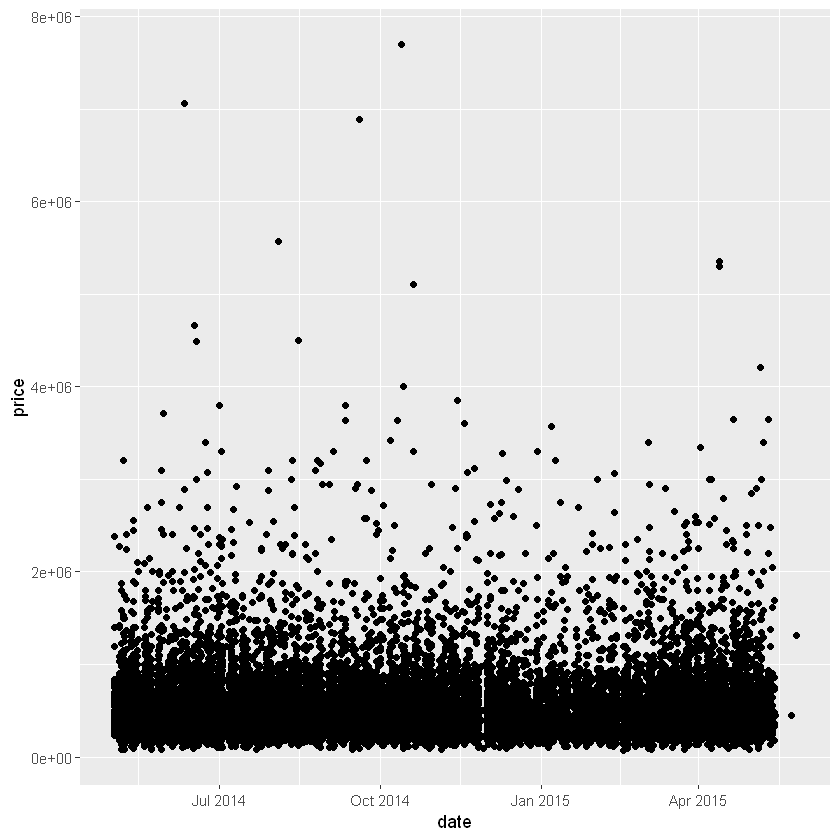

In [7]:
# visualize date and price relation
ggplot(df, aes(x=date, y=price)) +
    geom_point() # date & price

The scatter plot shows that there may not be as much of a correlation betwwen date and prices.It will help better understand the relationship and if there's a positive or negative correlation or it is more likely to predict the price. In case of categorical variables such as floors, the variation of prices is a good indicator of predictability.

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

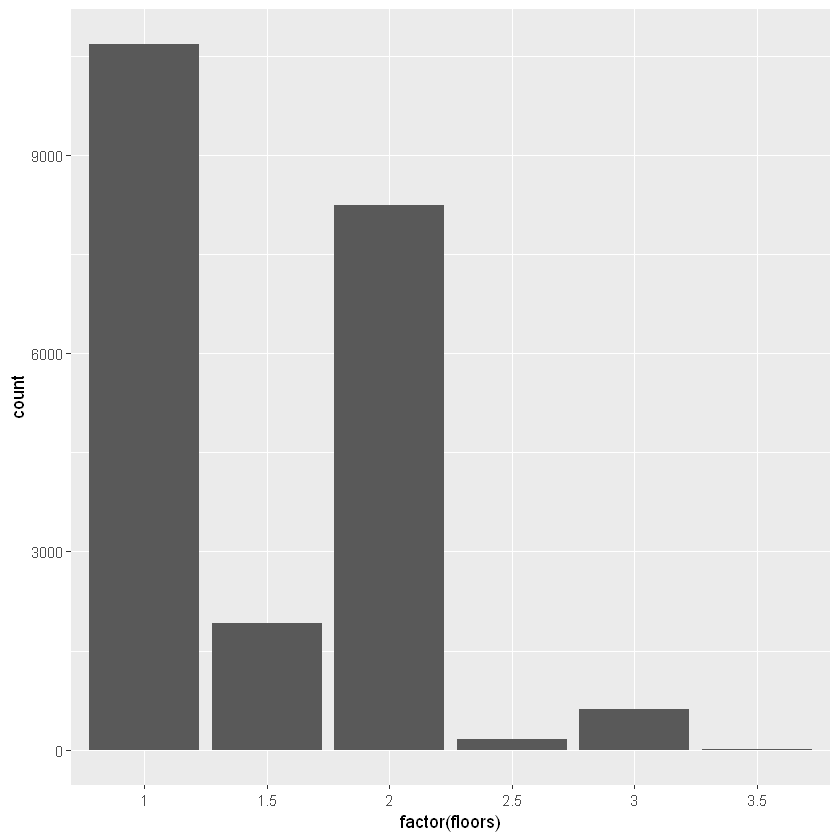

In [8]:
ggplot(df, aes(x=factor(floors))) +
    geom_histogram(stat = "count") # number of rooms by floors

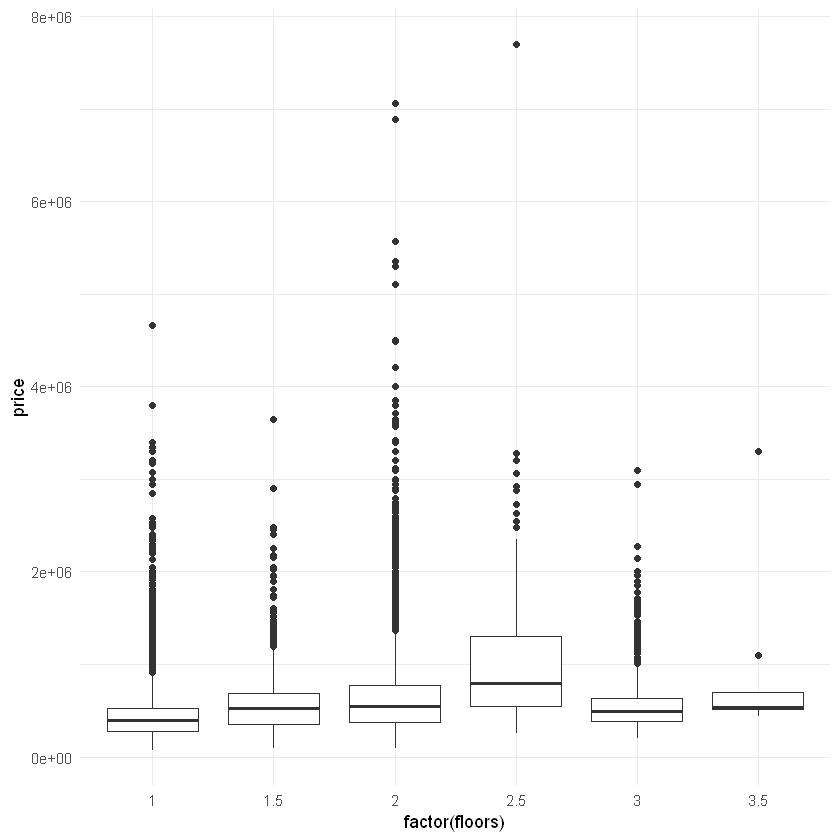

In [9]:
ggplot(df, aes(x=factor(floors), y=price)) +
    geom_boxplot() +
    theme_minimal() # floors & price

The plot shows that houses with 2.5 rooms have bigger interquartile range (higher variation) but despite that the majority of the houses either have 1 or 2 floors. Based on the boxplot we can also observe that the houses with one or two floors have quite a few outliers, meaning there are a lot of houses with prices far away from mean or even the majority of houses within in the interquartile range.

Understanding house prices based on geospatial data might also be an important aspect. We will try to visualize the location of houses based on their zipcode.

In [10]:
# zipcode library & ggmap will help us do that
library(zipcode)
data(zipcode)
head(zipcode)

zipcode.df <- zipcode %>%
    filter(zip %in% df$zipcode)

zipcode.df$zip <- as.integer(zipcode.df$zip) # convert to integer

# merge zipcode data with df in a new dataset for visualization purposes
df.map <- merge(df, zipcode.df, by.x = 'zipcode', by.y = 'zip') 

zip,city,state,latitude,longitude
00210,Portsmouth,NH,43.0059,-71.0132
00211,Portsmouth,NH,43.0059,-71.0132
00212,Portsmouth,NH,43.0059,-71.0132
00213,Portsmouth,NH,43.0059,-71.0132
00214,Portsmouth,NH,43.0059,-71.0132
00215,Portsmouth,NH,43.0059,-71.0132


In [11]:
# library for mapping
library(ggmap)

# getting the map
house_map <- get_map(location = c(lon = mean(df.map$longitude), lat = mean(df.map$latitude)), zoom = 10, maptype = "roadmap", scale = 2)

# visualze the house location
ggmap(house_map) + 
    geom_point(data=df.map, aes(x=longitude, y=latitude, fill='red', alpha=0.6, size=price), shape = 21) +
    guides(fill=FALSE, alpha=FALSE)

Warning message:
"package 'ggmap' was built under R version 3.5.3"Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.


ERROR: Error: Google now requires an API key.
       See ?register_google for details.


All of the zipcodes in the dataset are from Seattle. The houses are quite spread out in Seattle, and also the map show the size of the circle by price. There are areas where prices are more or less the same but some areas have more variability.

Let's visualize the relationship between zipcodes and price and better understand the relationship.

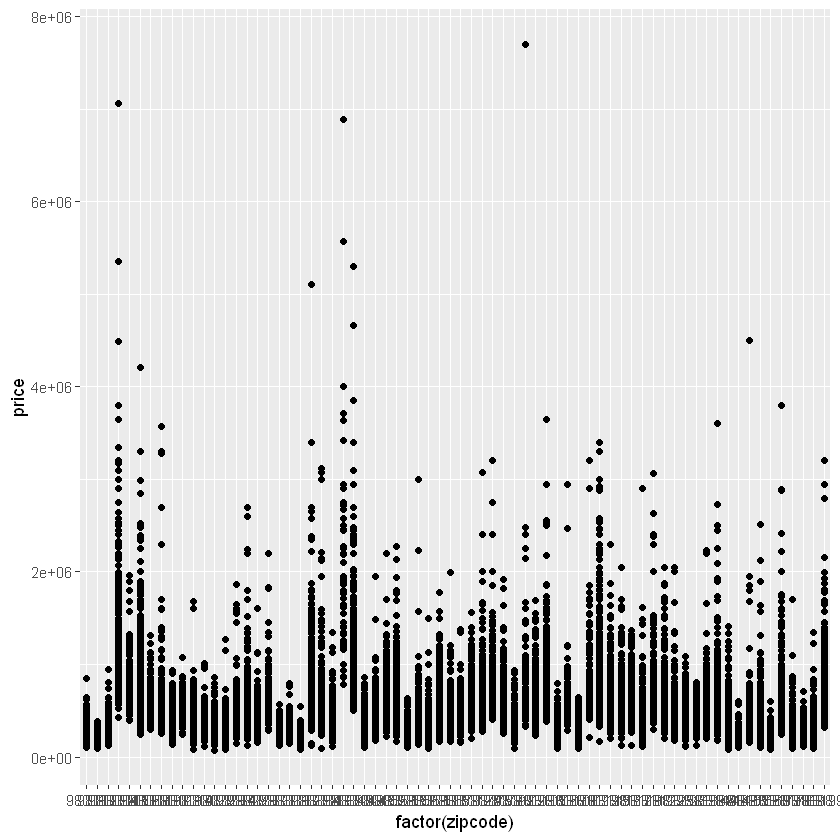

In [12]:
ggplot(df) +
    geom_point(aes(x=factor(zipcode), y=price))

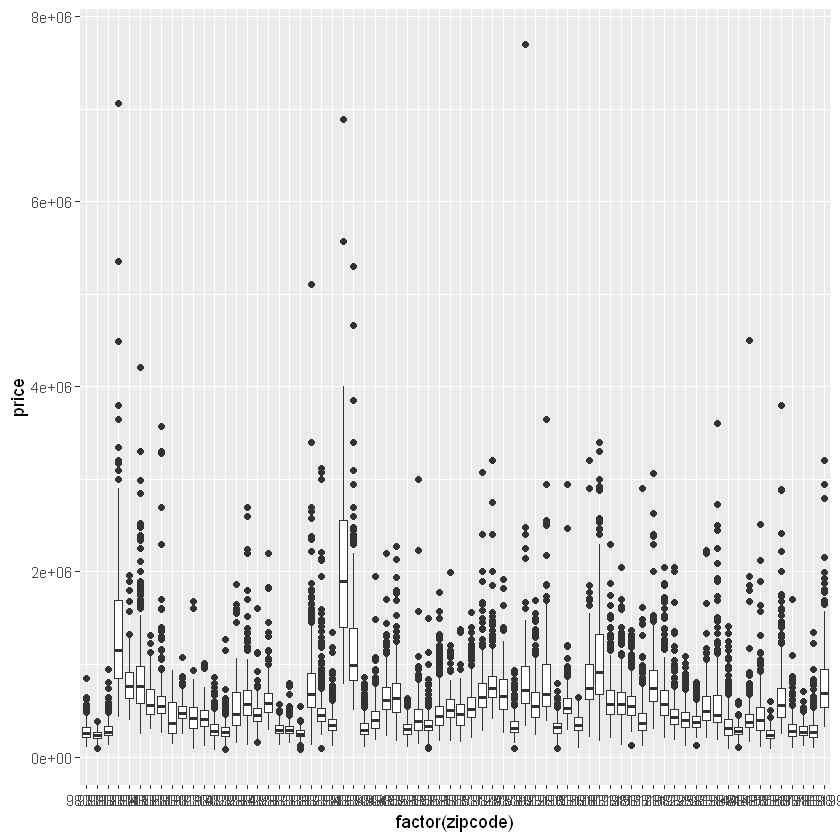

In [13]:
ggplot(df) +
    geom_boxplot(aes(x=factor(zipcode), y=price))

Scatter plot and the boxplot shows us that there are a group of zipcodes which have a relatively higher price range.

We will use this feature in our modeling. To keep it simple we will only use the zipcode.

Various indicators of house area are concluded inside 6 features

* sqft_living
* sqft_lot
* sqft_above
* sqft_basement
* sqft_living15
* sqft_lot15

We will visualize all of them relative to price.

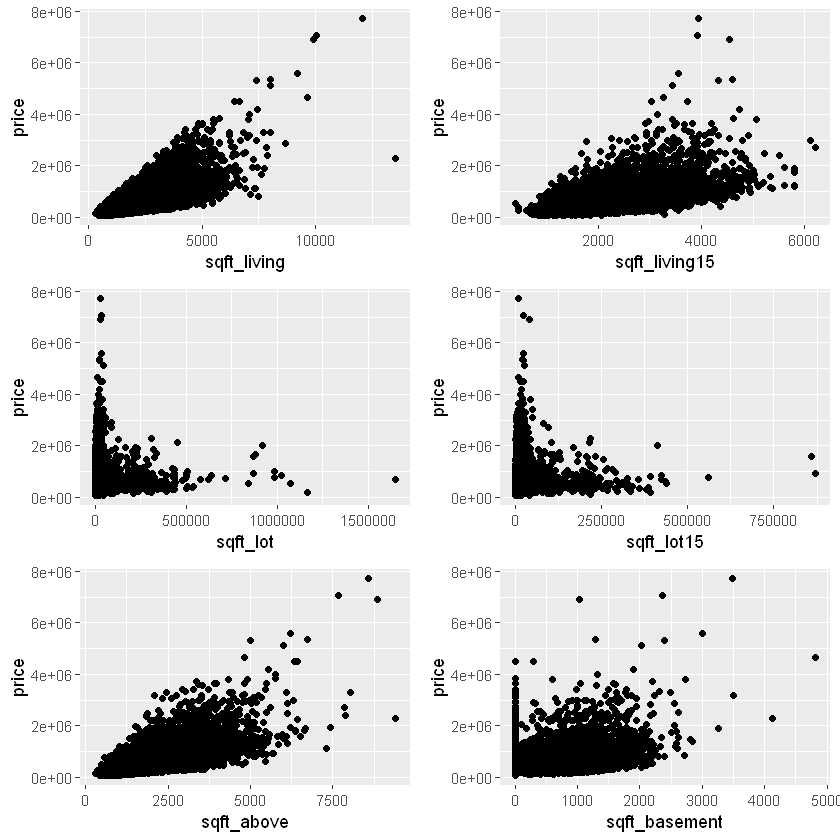

In [14]:
p2 <- ggplot(df, aes(x=sqft_living, y=price)) + geom_point() # sqft_living & price
p3 <- ggplot(df, aes(x=sqft_lot, y=price)) + geom_point() # sqft_lot & price
p9 <- ggplot(df, aes(x=sqft_above, y=price)) + geom_point() # sqft_above & price
p10 <- ggplot(df, aes(x=sqft_basement, y=price)) + geom_point() # sqft_basement & price
p14 <- ggplot(df, aes(x=sqft_living15, y=price)) + geom_point() # sqft_living15 vs price
p15 <- ggplot(df, aes(x=sqft_lot15, y=price)) + geom_point() # sqft_lot15 vs price
grid.arrange(p2, p14, p3, p15, p9, p10)

From the scatter plots, it seems that all of the above features have a positive correlation with price, with the exception of sqft_lot and sqft_lot15 where, quite a few of records have no sqft_lot or the ones that have are with less price. We will not use sqft_lot and sqft_lot15 for our price prediction.

Every house has rooms and that for sure should influence the price to a certain degree. 
Let's see how it does

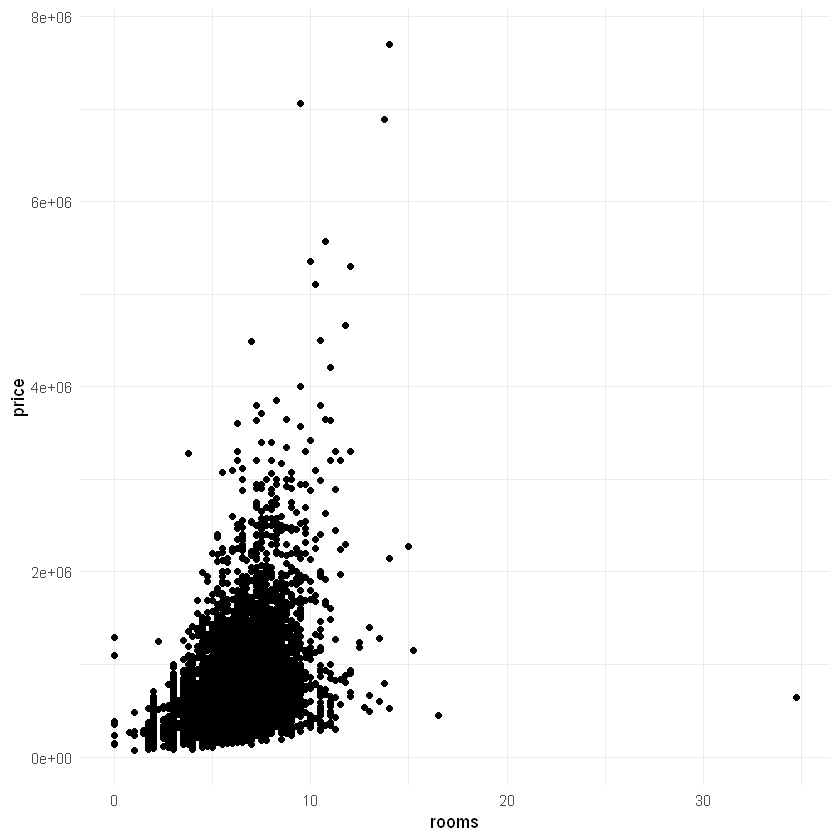

In [15]:
ggplot(df, aes(x=rooms, y=price)) +
    geom_point() + 
    theme_minimal()

There is an obvious correlation with more rooms a house has the higher its price.

Year built and year renovated would be an interesting and important feature that can help predict the price. Let's plot it

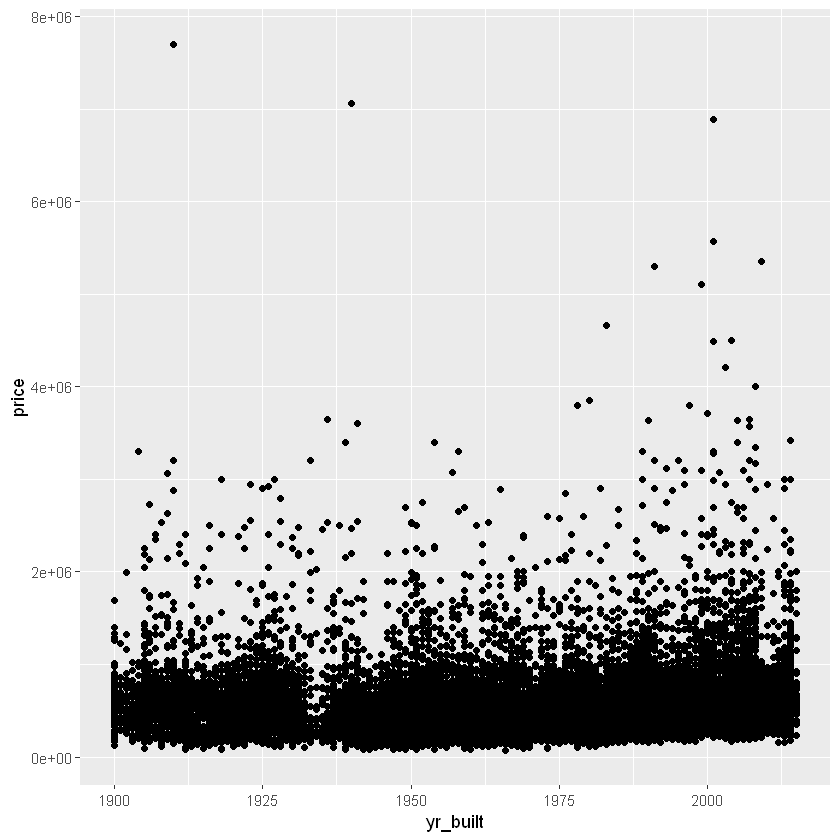

In [16]:
ggplot(df, aes(yr_built, price)) +
    geom_point() # year built vs price

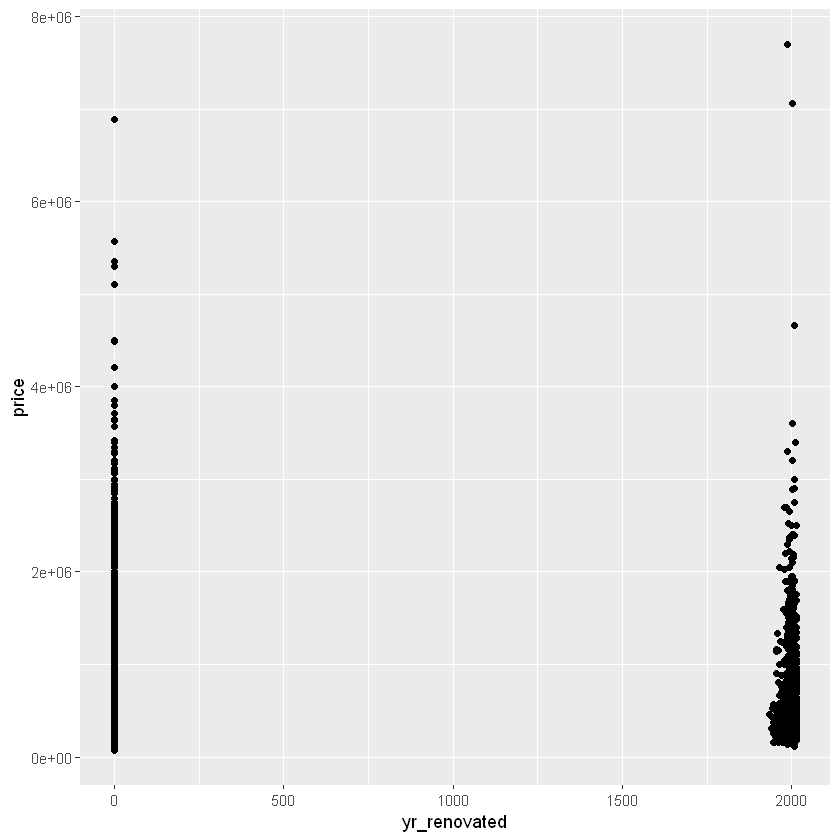

In [17]:
ggplot(df, aes(yr_renovated, price)) +
    geom_point() # year renovated vs price

It seems that if the house is not renovated then the value is 0, which kind of throws off the scaling for this feature. We will ignore it for now and won't use it for our prediction. Also grade and condition variables potentially capture the quality and condition of the house already.

We will use yr_built to generate age and see the correlation of the price vs age

In [18]:
df$age <- 2018 - df$yr_built
summary(df$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00   21.00   43.00   46.99   67.00  118.00 

It seems that the youngest house is 3 years old while the oldest is 118.

Let's see the correlation with price.

[1] -0.05401153

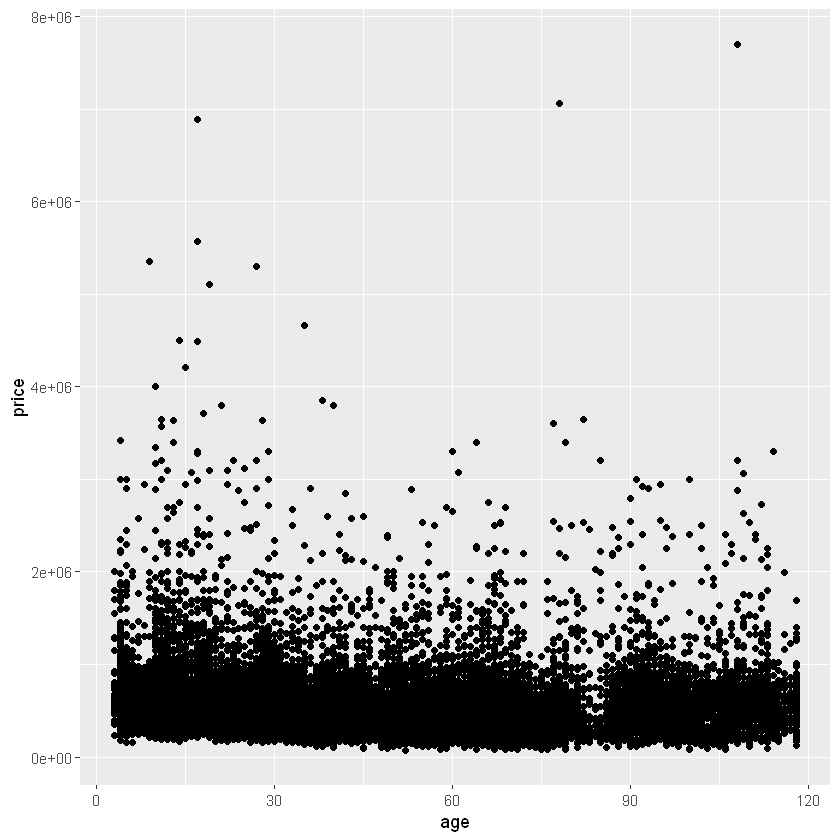

In [19]:
ggplot(df, aes(age, price)) +
    geom_point()

cor(df$price, df$age)

The plot and the correlation coefficient also reinforces the previous plot. There is almost non-existant effect of age or year built on price.

Waterfront and View are categorical variables. Waterfront 0 or 1 indicates whether the house has waterfront or not.

View with values from 0 to 4 shows the quality of the view.

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

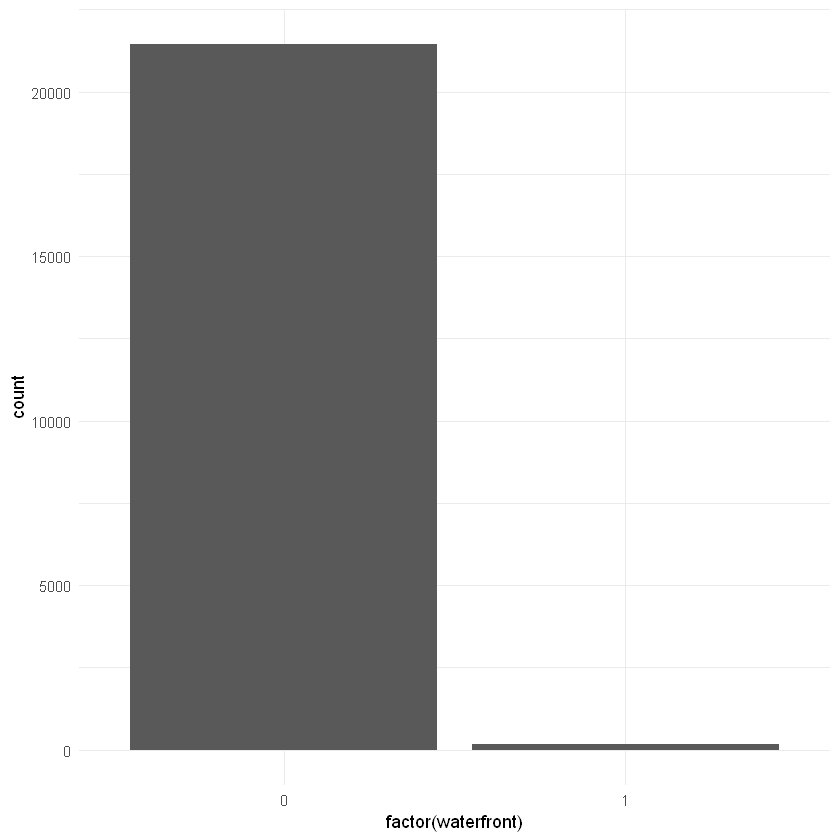

In [20]:
ggplot(df, aes(factor(waterfront))) +
    geom_histogram(stat = "count") +
    theme_minimal() # number of houses by waterfront

There are definitely more houses with waterfront than not.

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

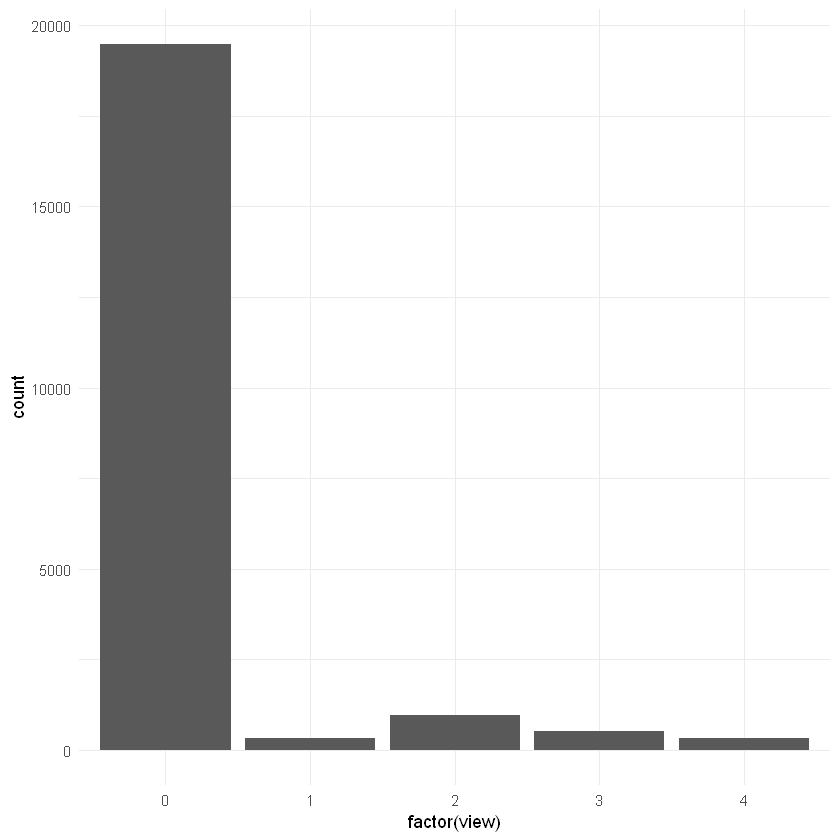

In [21]:
ggplot(df, aes(factor(view))) +
    geom_histogram(stat = "count") +
    theme_minimal() # number of houses by view

As with waterfront majority of houses don't have a view or have a poor view.

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

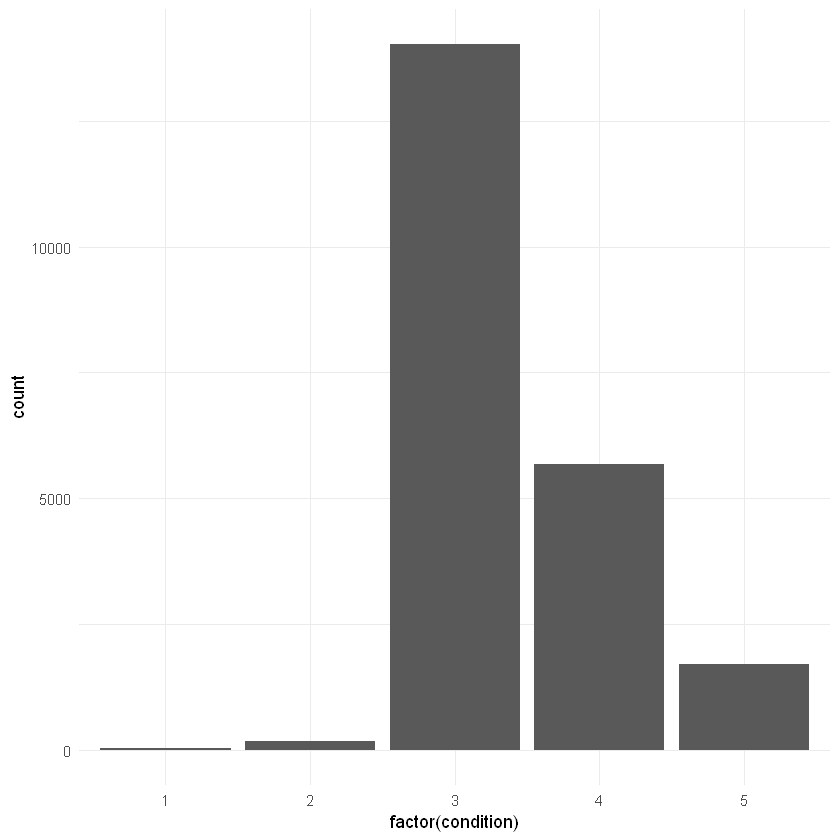

In [22]:
ggplot(df, aes(factor(condition))) +
    geom_histogram(stat = "count") +
    theme_minimal() # number of houses by condition

Most of the houses have an average view

Grades allow categorizing houses by their prestige and quality

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

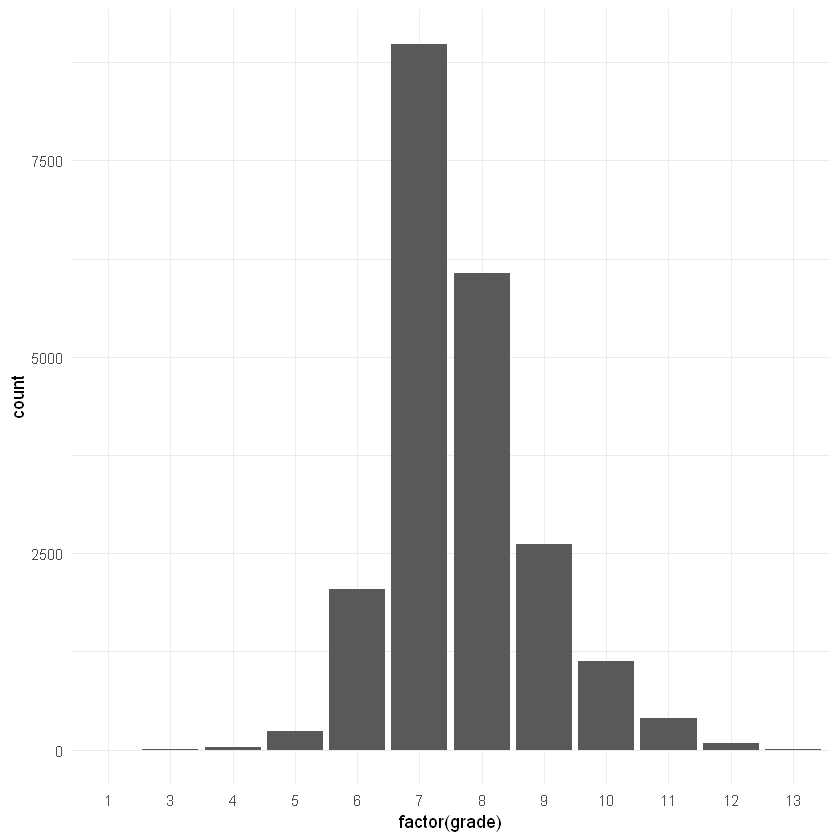

In [23]:
ggplot(df, aes(factor(grade))) +
    geom_histogram(stat = "count") +
    theme_minimal() # number of houses by grade

Houses are normally distributed when it comes to grade and most of them are average grade which is 7.

## Price Prediction

To develop a good model which predicts well we will set up 3 different models with various interactiona and test those models for accuracy. Our accuracy measure will be MSE.

### Train & Test Split

In [24]:
sample <- sample(c(TRUE, FALSE), nrow(df), replace = T, prob = c(0.6,0.4))

# train and test sets
df_train <- df[sample,]
df_test <- df[!sample,]

### Modeling

We will use 3 different models utilizing linear regression.
To compare the accuracy, we will also use 2 models using random forest regression.

#### Model 1

Our first model will be quite simple, since we will only use the following features that we think will better predict the price

* rooms
* floors
* zipcode
* grade
* age

In [25]:
model1 <- lm(price ~ rooms + floors + zipcode + grade + age, data = df_train)
summary(model1)


Call:
lm(formula = price ~ rooms + floors + zipcode + grade + age, 
    data = df_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-895468 -127566  -18379   88113 5495219 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.787e+06  4.221e+06  -0.660    0.509    
rooms        4.241e+04  1.803e+03  23.525  < 2e-16 ***
floors       2.661e+04  4.808e+03   5.534 3.19e-08 ***
zipcode      1.237e+01  4.305e+01   0.287    0.774    
grade        2.147e+05  2.406e+03  89.224  < 2e-16 ***
age          4.158e+03  9.138e+01  45.497  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 241800 on 12980 degrees of freedom
Multiple R-squared:  0.5404,	Adjusted R-squared:  0.5402 
F-statistic:  3053 on 5 and 12980 DF,  p-value: < 2.2e-16


The model1 can only explain 54% of variation in price. (R squared)

#### Model 2

Our second model will use the following features

* sqft_living
* sqft_lot
* sqft_above
* sqft_basement
* floors
* condition
* zipcode

In [26]:
model2 <- lm(price ~ sqft_living + sqft_lot + sqft_above + sqft_basement + zipcode, data = df_train)

summary(model2)


Call:
lm(formula = price ~ sqft_living + sqft_lot + sqft_above + sqft_basement + 
    zipcode, data = df_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1394083  -142278   -23411   103514  4341128 

Coefficients: (1 not defined because of singularities)
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -6.295e+07  4.223e+06  -14.91  < 2e-16 ***
sqft_living    2.749e+02  5.026e+00   54.70  < 2e-16 ***
sqft_lot      -2.010e-01  5.247e-02   -3.83 0.000129 ***
sqft_above     7.754e+00  5.658e+00    1.37 0.170567    
sqft_basement         NA         NA      NA       NA    
zipcode        6.414e+02  4.305e+01   14.90  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 252400 on 12981 degrees of freedom
Multiple R-squared:  0.4992,	Adjusted R-squared:  0.4991 
F-statistic:  3235 on 4 and 12981 DF,  p-value: < 2.2e-16


The model1 can only explain ~49% of variation in price. (R squared)

#### Model 3

Here we will simply add all of the available features and see how the model performs.

In [27]:
model3 <- lm(price ~ date + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + yr_built + 
             yr_renovated + zipcode + sqft_living15 + sqft_lot15 + rooms + age, data = df_train)

summary(model3)


Call:
lm(formula = price ~ date + sqft_living + sqft_lot + floors + 
    waterfront + view + condition + grade + sqft_above + sqft_basement + 
    yr_built + yr_renovated + zipcode + sqft_living15 + sqft_lot15 + 
    rooms + age, data = df_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1266807  -111324    -7244    88200  4392389 

Coefficients: (2 not defined because of singularities)
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -4.476e+06  3.990e+06  -1.122 0.261948    
date           9.463e+01  1.661e+01   5.696 1.26e-08 ***
sqft_living    1.730e+02  5.855e+00  29.557  < 2e-16 ***
sqft_lot       8.813e-03  6.460e-02   0.136 0.891485    
floors         4.346e+04  4.731e+03   9.186  < 2e-16 ***
waterfront     5.469e+05  2.416e+04  22.634  < 2e-16 ***
view           4.240e+04  2.902e+03  14.611  < 2e-16 ***
condition      2.047e+04  3.216e+03   6.367 2.00e-10 ***
grade          1.232e+05  2.868e+03  42.952  < 2e-16 ***
sqft_above    -9.247e+

The model 3 shows a 64% R squared, but we will compare the MSE to other models.

#### Model 4

We will use features we used in our first model but this time use random forest regression to predict price.

* rooms
* floors
* zipcode
* grade
* age

In [34]:
# load Random Forest algorithm
require(randomForest)
model4 <- randomForest(price ~ rooms + floors + zipcode + grade + age, data=df_train)
summary(model4)

                Length Class  Mode     
call                3  -none- call     
type                1  -none- character
predicted       12986  -none- numeric  
mse               500  -none- numeric  
rsq               500  -none- numeric  
oob.times       12986  -none- numeric  
importance          5  -none- numeric  
importanceSD        0  -none- NULL     
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             11  -none- list     
coefs               0  -none- NULL     
y               12986  -none- numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

The Graph of the random forest

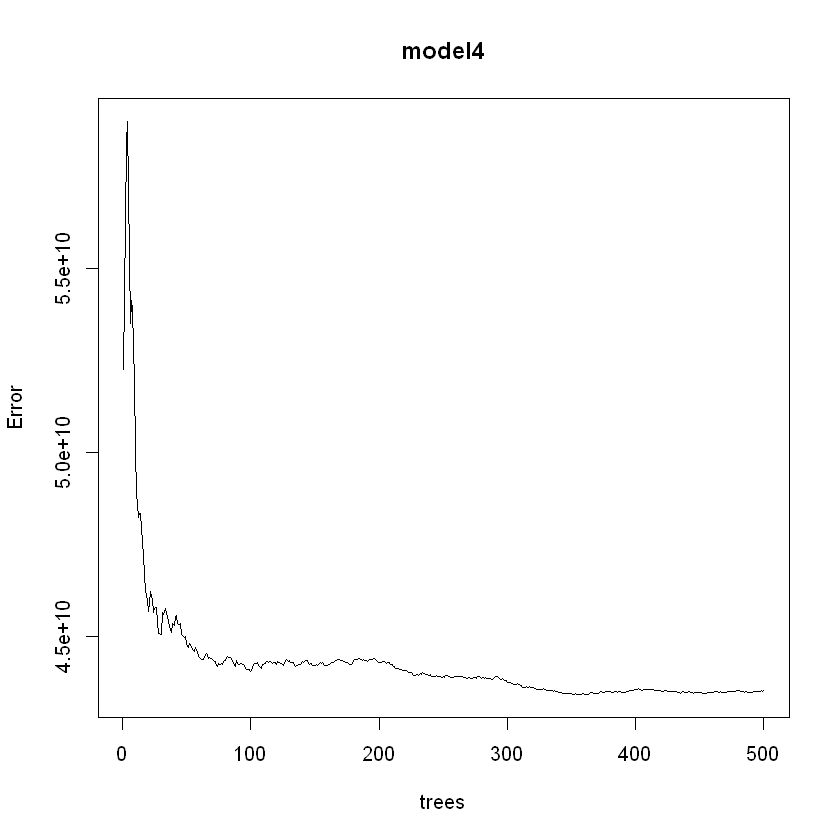

In [29]:
plot(model4)

#### Model 5

Let's now use features from our second model with random forest regression and observe the model.

* sqft_living
* sqft_lot
* sqft_above
* sqft_basement
* floors
* condition
* zipcode

In [30]:
model5 <- randomForest(price ~ sqft_living + sqft_lot + sqft_above + sqft_basement + zipcode, data = df_train)
summary(model5)

                Length Class  Mode     
call                3  -none- call     
type                1  -none- character
predicted       12986  -none- numeric  
mse               500  -none- numeric  
rsq               500  -none- numeric  
oob.times       12986  -none- numeric  
importance          5  -none- numeric  
importanceSD        0  -none- NULL     
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             11  -none- list     
coefs               0  -none- NULL     
y               12986  -none- numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

Graph of model5

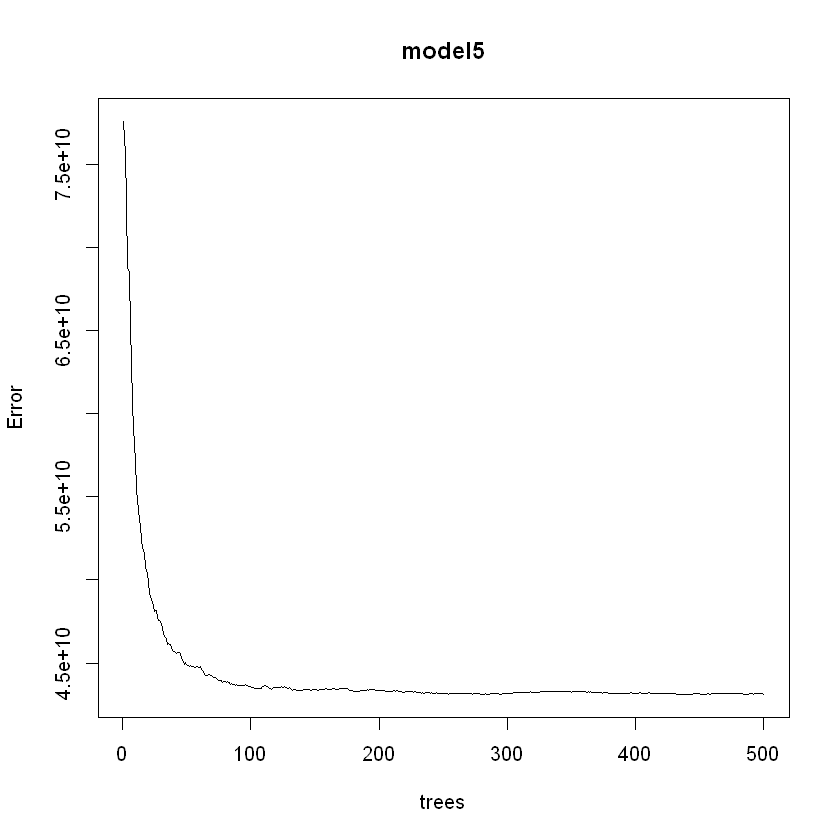

In [31]:
plot(model5)

## Evaluation

Let's evaluate the 5 models we have built.
We will use MSE as a measure of effectiveness.

### Comparing predictions

Let's compare the prediction quality of each of the model using MSE

In [33]:
df_test %>%
    gather_predictions(model1, model2, model3, model4, model5) %>%
    group_by(model) %>%
    summarise(MSE = mean((price-pred)^2))

Warning message in predict.lm(model, data):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(model, data):
"prediction from a rank-deficient fit may be misleading"

model,MSE
model1,66712303024
model2,72725946704
model3,50544901202
model4,48191904575
model5,47536607299


Based on the above table, it does seem that Random Forest regression for our model with the following features proved to have a smaller MSE. This doesn't always mean that in production it will be very effective but taking into account the current task, it does prove to be relatively accurate.